### Necessary Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.utils.data
from torch.autograd import Variable
from torchsummary import summary
from torchvision.utils import save_image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
transform = transforms.ToTensor()

## Data Preprocessing 

### Load the training set

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
train_data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [ ]:
test_data = datasets.MNIST(root='Data', train=False, download=True, transform=transform)
test_data

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw

Processing...
Done!


Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
model_data=train_data+test_data
total_count=len(model_data)
total_count

70000

### Split 70:30

In [ ]:
train_count = int(0.7 * total_count) 
test_count = int(0.3 * total_count)

In [ ]:
train_data, test_data = torch.utils.data.random_split(model_data, (train_count, test_count))
print(len(train_data))
print(len(test_data))
type(train_data)

49000
21000


torch.utils.data.dataset.Subset

In [ ]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Calling the first record from <tt>train_data</tt> returns a two-item tuple. The first item is our 28x28 tensor representing the image. The second is a label, in this case the number "5".

In [ ]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 1


### View the image
Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

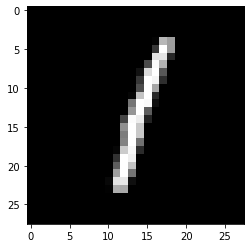

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");


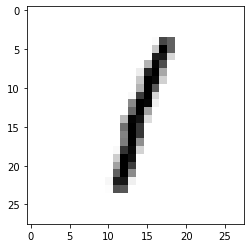

In [ ]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [ ]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

### View a batch of images


Labels:  [   1    3    8    6    0    0    6    1    3    4    8    0]


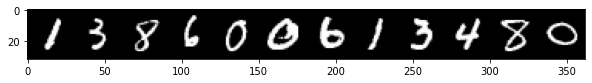

In [ ]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [ ]:
images.view(100,-1).size()

torch.Size([100, 784])

### Supporting functions

In [ ]:
def plot_loss(train_losses,test_losses):
  plt.plot(train_losses, label='training loss')
  plt.plot(test_losses, label='test reconstruction loss')
  plt.title('Loss at the end of each epoch')
  plt.legend();

In [ ]:
def plot_accuracy(train_correct,test_correct):
  plt.plot([t/49000 for t in train_correct], label='training accuracy')
  plt.plot([t/21000 for t in test_correct], label='test reconstruction accuracy')
  plt.title('Accuracy at the end of each epoch')
  plt.legend();

### Train the model


In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [ ]:

def train_loss_accuracy(train_loader,model):

  import time
  start_time = time.time()

  epochs = 10
  train_losses = []
  test_losses = []
  train_correct = []
  test_correct = []
  
  

  for i in range(epochs):
      trn_corr = 0
      tst_corr = 0
      
      # Run the training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b+=1
          # Apply the model
          y_pred= model(X_train.view(100, -1))  # Here we flatten X_train
          loss = criterion(y_pred, y_train)
  
          # Tally the number of correct predictions
          predicted = torch.max(y_pred.data, 1)[1]
          batch_corr = (predicted == y_train).sum()
          trn_corr += batch_corr
          
          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print interim results
          if b%200 == 0:
              print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/49000]  loss: {loss.item():10.8f}  \
  accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
      
      # Update train loss & accuracy for the epoch
      train_losses.append(loss)
      train_correct.append(trn_corr)
      # Run the testing batches
      with torch.no_grad():
          for b, (X_test, y_test) in enumerate(test_loader):

              # Apply the model
              y_val = model(X_test.view(500, -1))  # Here we flatten X_test

              # Tally the number of correct predictions
              predicted = torch.max(y_val.data, 1)[1] 
              tst_corr += (predicted == y_test).sum()
      
      # Update test loss & accuracy for the epoch
      loss = criterion(y_val, y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)
          
  print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  


  return train_losses,train_correct,test_losses,test_correct    #,final_outputs    

In [ ]:
def save_train_dataset(train_loader,model,hidden_neurons):
  train_outputs = np.empty((0,hidden_neurons), float)
  target_train= np.empty((0,1), int)
  # Run the training batches
  for b, (X_train, y_train) in enumerate(train_loader):
      #print(y_train)

      b+=1
      # Apply the model
      y_pred= model(X_train.view(100, -1))  # Here we flatten X_train
      target_train = np.append(target_train,y_train.numpy().reshape(-1,1),axis=0)
      
      outputs=model.get_output()
      outputs = outputs.cpu().data
      train_outputs = np.append( train_outputs, outputs.numpy(), axis=0)  
    
  np.save('train.npy', train_outputs)
  np.save('train-labels.npy', target_train)

In [ ]:
def save_test_dataset(test_loader,model,hidden_neurons):
  test_outputs =  np.empty((0,hidden_neurons),float)
  test_target= np.empty((0,1), int)
  
  # Run the training batches
  for b, (X_test, y_test) in enumerate(test_loader):
      b+=1
      # Apply the model
      y_pred= model(X_test.view(500, -1))  # Here we flatten X_train
      test_target = np.append(test_target,y_test.numpy().reshape(-1,1),axis=0)
      
      outputs=model.get_output()
      outputs = outputs.cpu().data
      test_outputs = np.append( test_outputs, outputs.numpy(), axis=0)  
     
  np.save('test.npy', test_outputs)
  np.save('test-labels.npy', test_target)

In [ ]:
# Run the testing batches
def test_loss_accuracy(test_data,model):
  
  test_load_all = DataLoader(test_data, batch_size=21000, shuffle=False)
  test_losses=[]
  with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
       
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        loss = criterion(y_val, y_test)

        test_losses.append(loss)
  print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')
  return  (correct.item()*100/(len(test_data)),test_losses)

### Defining the Model

In [ ]:
test_accuracies=[]
test_losses_terms=[]

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[256,128,64,32]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],layers[2])
        self.fc4 = nn.Linear(layers[2],layers[3])
        self.fc5 = nn.Linear(layers[3],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return F.log_softmax(X, dim=1)

### Adam Optimiser

In [ ]:
torch.manual_seed(101)
modelAdam = MultilayerPerceptron()
modelAdam

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelAdam.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelAdam)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelAdam)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.54638976    accuracy:  75.785%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.16015981    accuracy:  83.195%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.17800318    accuracy:  94.180%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.11839499    accuracy:  94.530%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.04056558    accuracy:  96.210%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.09582682    accuracy:  96.338%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.05963653    accuracy:  97.360%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.29221302    accuracy:  97.375%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.04916584    accuracy:  97.965%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.07079864    accuracy:  98.002%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.03407855    accuracy:  98.490%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.01872159    accuracy:  98.355%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.06621452    accur

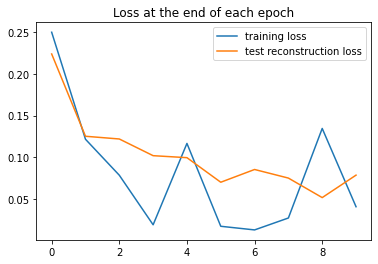

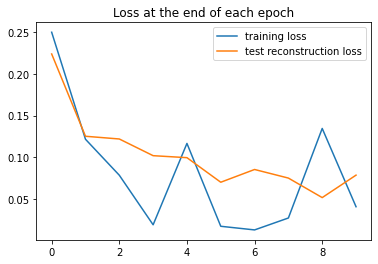

In [ ]:
plot_loss(train_losses,test_losses)

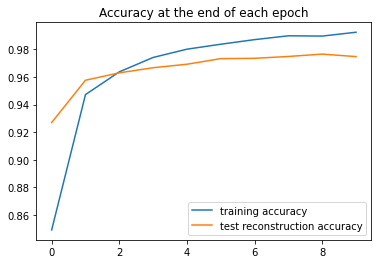

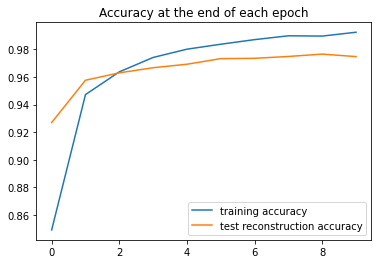

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelAdam)

Test accuracy: 20469/21000 =  97.471%


In [ ]:
test_accuracy

97.47142857142858

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.10777304321527481


In [ ]:
test_accuracies.append(test_accuracy)
test_losses_terms.append(loss_term)

### RMSProp optimizer

In [ ]:
torch.manual_seed(101)
modelRMS = MultilayerPerceptron()
modelRMS

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelRMS)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelRMS)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.39139628    accuracy:  79.735%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.13674583    accuracy:  86.155%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.13869113    accuracy:  95.305%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.09425397    accuracy:  95.532%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.04789856    accuracy:  96.825%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.04314962    accuracy:  97.040%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.07141519    accuracy:  97.675%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.14505953    accuracy:  97.722%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.02542600    accuracy:  98.510%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.11768746    accuracy:  98.382%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.04473504    accuracy:  98.765%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.00254129    accuracy:  98.683%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.02188082    accur

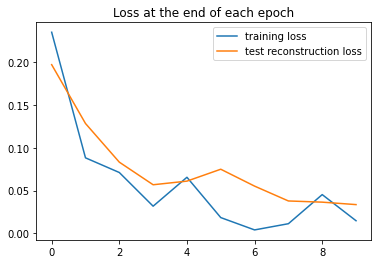

In [ ]:
plot_loss(train_losses,test_losses)

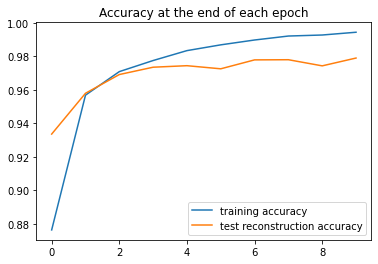

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)

Test accuracy: 20558/21000 =  97.895%


In [ ]:
test_accuracy

97.8952380952381

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.09146009385585785


In [ ]:
test_accuracies.append(test_accuracy)
test_losses_terms.append(loss_term)

In [ ]:
torch.save(modelRMS.state_dict(), 'RMSProp-Best-Model.pt')

### SGD with  no Momentum

In [ ]:
torch.manual_seed(101)
modelSGD = MultilayerPerceptron()
modelSGD

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelSGD.parameters(), lr=0.01,momentum=0)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelSGD)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelSGD)

epoch:  0  batch:  200 [ 20000/49000]  loss: 2.31428289    accuracy:  11.345%
epoch:  0  batch:  400 [ 40000/49000]  loss: 2.29882145    accuracy:  11.203%
epoch:  1  batch:  200 [ 20000/49000]  loss: 2.28122592    accuracy:  11.475%
epoch:  1  batch:  400 [ 40000/49000]  loss: 2.28698850    accuracy:  11.547%
epoch:  2  batch:  200 [ 20000/49000]  loss: 2.25974941    accuracy:  16.990%
epoch:  2  batch:  400 [ 40000/49000]  loss: 2.23086643    accuracy:  20.570%
epoch:  3  batch:  200 [ 20000/49000]  loss: 2.09267068    accuracy:  28.095%
epoch:  3  batch:  400 [ 40000/49000]  loss: 1.86578929    accuracy:  27.872%
epoch:  4  batch:  200 [ 20000/49000]  loss: 1.41147268    accuracy:  45.975%
epoch:  4  batch:  400 [ 40000/49000]  loss: 1.12040067    accuracy:  51.562%
epoch:  5  batch:  200 [ 20000/49000]  loss: 1.01646996    accuracy:  70.655%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.61306292    accuracy:  73.655%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.57477456    accur

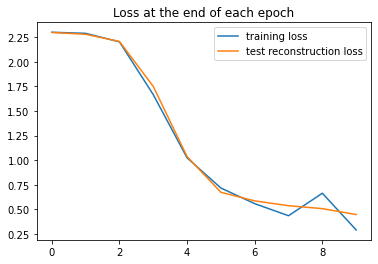

In [ ]:
plot_loss(train_losses,test_losses)

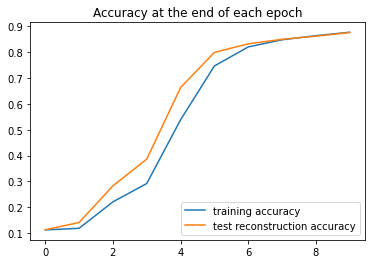

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelSGD)

Test accuracy: 18411/21000 =  87.671%


In [ ]:
test_accuracy


87.67142857142858

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.43271884322166443


In [ ]:
test_accuracies.append(test_accuracy)
test_losses_terms.append(loss_term)

### SGD with Momentum

In [ ]:
torch.manual_seed(101)
modelSGD = MultilayerPerceptron()
modelSGD

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelSGD.parameters(), lr=0.001,momentum=0.9)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelSGD)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelSGD)

epoch:  0  batch:  200 [ 20000/49000]  loss: 2.31456232    accuracy:  11.320%
epoch:  0  batch:  400 [ 40000/49000]  loss: 2.29907727    accuracy:  11.190%
epoch:  1  batch:  200 [ 20000/49000]  loss: 2.28193521    accuracy:  11.475%
epoch:  1  batch:  400 [ 40000/49000]  loss: 2.28799295    accuracy:  11.438%
epoch:  2  batch:  200 [ 20000/49000]  loss: 2.26274514    accuracy:  15.810%
epoch:  2  batch:  400 [ 40000/49000]  loss: 2.23734808    accuracy:  19.360%
epoch:  3  batch:  200 [ 20000/49000]  loss: 2.12873864    accuracy:  28.225%
epoch:  3  batch:  400 [ 40000/49000]  loss: 1.91130555    accuracy:  27.785%
epoch:  4  batch:  200 [ 20000/49000]  loss: 1.49338007    accuracy:  42.615%
epoch:  4  batch:  400 [ 40000/49000]  loss: 1.17006767    accuracy:  48.513%
epoch:  5  batch:  200 [ 20000/49000]  loss: 1.08946097    accuracy:  68.240%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.64597952    accuracy:  71.935%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.59020829    accur

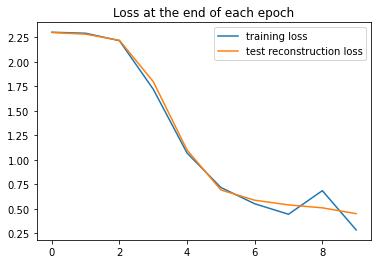

In [ ]:
plot_loss(train_losses,test_losses)

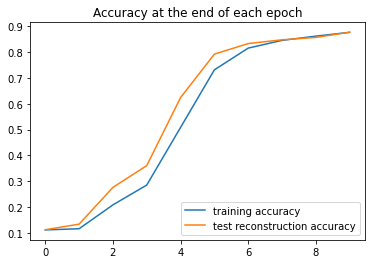

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelSGD)

Test accuracy: 18411/21000 =  87.671%


In [ ]:
test_accuracy

87.67142857142858

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.43271884322166443


In [ ]:
test_accuracies.append(test_accuracy)
test_losses_terms.append(loss_term)

In [ ]:

print(test_accuracies)
print(test_losses_terms)

[97.47142857142858, 97.8952380952381, 87.67142857142858, 87.67142857142858]
[0.10777304321527481, 0.09146009385585785, 0.43271884322166443, 0.43271884322166443]


### Graphs comparing the losses and accuracies of test data

In [ ]:
def plot_bar_graph(left,height,tick_label,score='loss',title='Loss vs optimizer'):
  # x-coordinates of left sides of bars 
 
    
  # plotting a bar chart
  plt.bar(left, height, tick_label = tick_label,
          width = 0.8, color = ['red', 'green','yellow','blue'])
    
  # naming the x-axis
  plt.xlabel('Optimizers')
  # naming the y-axis
  plt.ylabel(score)
  # plot title
  plt.title(title)
    
  # function to show the plot
  plt.show()

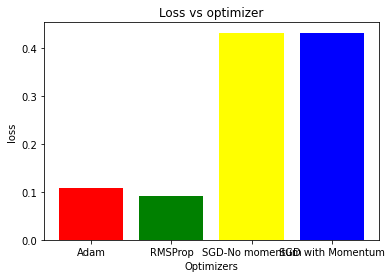

In [ ]:
left=[1,2,3,4]
height=test_losses_terms
tick_label=['Adam','RMSProp','SGD-No momentum','SGD with Momentum']
plot_bar_graph(left,height,tick_label)

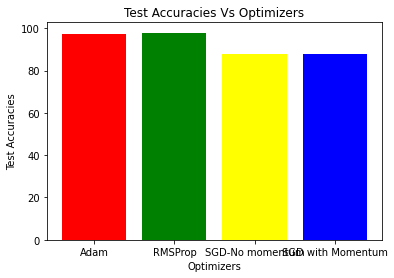

In [ ]:
left=[1,2,3,4]
height=test_accuracies
tick_label=['Adam','RMSProp','SGD-No momentum','SGD with Momentum']
plot_bar_graph(left,height,tick_label,score='Test Accuracies',title='Test Accuracies Vs Optimizers')

## Weight Initialisations
   We are taking the best model RMSProp and performing different weight initialisation methods 

### Defining new Models for each weight intialisation

### Xavier weight intialisation

In [ ]:
weight_accuracies=[]
weight_losses=[]

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[256,128,64,32]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        nn.init.xavier_normal_(self.fc1.weight,gain=nn.init.calculate_gain('relu'))
        self.fc2 = nn.Linear(layers[0],layers[1])
        nn.init.xavier_normal_(self.fc2.weight,gain=nn.init.calculate_gain('relu'))
        self.fc3 = nn.Linear(layers[1],layers[2])
        nn.init.xavier_normal_(self.fc3.weight,gain=nn.init.calculate_gain('relu'))
        self.fc4 = nn.Linear(layers[2],layers[3])
        nn.init.xavier_normal_(self.fc4.weight,gain=nn.init.calculate_gain('relu'))
        self.fc5 = nn.Linear(layers[3],out_sz)
        nn.init.xavier_normal_(self.fc5.weight,gain=nn.init.calculate_gain('relu'))
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
modelRMS = FeedForwardNetwork()
modelRMS

FeedForwardNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelRMS)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelRMS)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.22455794    accuracy:  85.780%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.10472813    accuracy:  90.157%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.07140334    accuracy:  96.580%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.11799471    accuracy:  96.603%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.14713210    accuracy:  97.900%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.06534830    accuracy:  97.685%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.02152938    accuracy:  98.645%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.02235299    accuracy:  98.360%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.03420917    accuracy:  98.875%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.04519747    accuracy:  98.733%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.06283142    accuracy:  99.035%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.07785881    accuracy:  98.987%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.00475517    accur

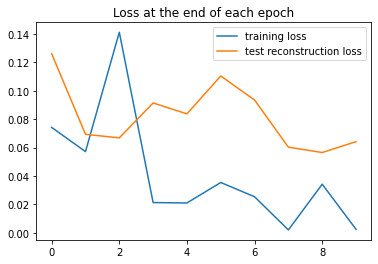

In [ ]:
plot_loss(train_losses,test_losses)

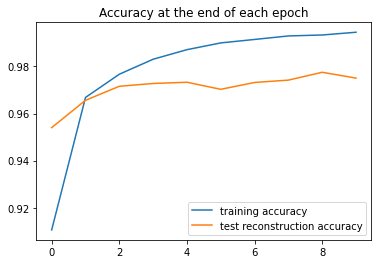

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)

Test accuracy: 20476/21000 =  97.505%


In [ ]:
test_accuracy

97.5047619047619

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.10998515039682388


In [ ]:
weight_accuracies.append(test_accuracy)


In [ ]:
weight_losses.append(loss_term)

### Uniform weight intisalization

In [ ]:
class FeedForwardUniform(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[256,128,64,32]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        nn.init.uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(layers[0],layers[1])
        nn.init.uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(layers[1],layers[2])
        nn.init.uniform_(self.fc3.weight)
        self.fc4 = nn.Linear(layers[2],layers[3])
        nn.init.uniform_(self.fc4.weight)
        self.fc5 = nn.Linear(layers[3],out_sz)
        nn.init.uniform_(self.fc5.weight)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(101)
modelRMSUniform = FeedForwardUniform()
modelRMSUniform

FeedForwardUniform(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(modelRMSUniform.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelRMSUniform)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelRMSUniform)

epoch:  0  batch:  200 [ 20000/49000]  loss: 281667.46875000    accuracy:  10.295%
epoch:  0  batch:  400 [ 40000/49000]  loss: 398803.43750000    accuracy:  10.088%
epoch:  1  batch:  200 [ 20000/49000]  loss: 115184.28906250    accuracy:  10.065%
epoch:  1  batch:  400 [ 40000/49000]  loss: 8213.29980469    accuracy:  10.300%
epoch:  2  batch:  200 [ 20000/49000]  loss: 295.23104858    accuracy:  28.365%
epoch:  2  batch:  400 [ 40000/49000]  loss: 85.67270660    accuracy:  43.640%
epoch:  3  batch:  200 [ 20000/49000]  loss: 9.89226723    accuracy:  75.220%
epoch:  3  batch:  400 [ 40000/49000]  loss: 2.76257014    accuracy:  76.920%
epoch:  4  batch:  200 [ 20000/49000]  loss: 1.60003698    accuracy:  76.155%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.82549095    accuracy:  73.440%
epoch:  5  batch:  200 [ 20000/49000]  loss: 1.13201153    accuracy:  69.900%
epoch:  5  batch:  400 [ 40000/49000]  loss: 2.98792815    accuracy:  65.338%
epoch:  6  batch:  200 [ 20000/49000]  loss

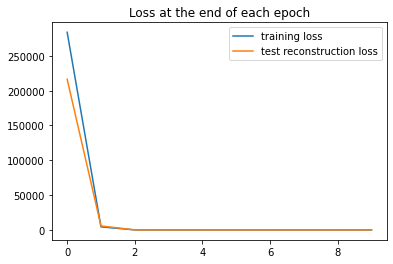

In [ ]:
plot_loss(train_losses,test_losses)

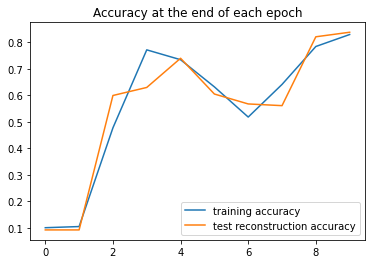

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMSUniform)

Test accuracy: 17591/21000 =  83.767%


In [ ]:
test_accuracy

83.76666666666667

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.7427265048027039


In [ ]:
weight_accuracies.append(test_accuracy)


In [ ]:
weight_losses.append(loss_term)

### Normal weight Intialisation

In [ ]:
class FeedForwardNormal(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[256,128,64,32]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        nn.init.normal_(self.fc1.weight)
        self.fc2 = nn.Linear(layers[0],layers[1])
        nn.init.normal_(self.fc2.weight)
        self.fc3 = nn.Linear(layers[1],layers[2])
        nn.init.normal_(self.fc3.weight)
        self.fc4 = nn.Linear(layers[2],layers[3])
        nn.init.normal_(self.fc4.weight)
        self.fc5 = nn.Linear(layers[3],out_sz)
        nn.init.normal_(self.fc5.weight)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = self.fc5(X)
        return F.log_softmax(X, dim=1)
        

In [ ]:
torch.manual_seed(101)
modelRMSNormal = FeedForwardNormal()
modelRMSNormal

FeedForwardNormal(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(modelRMSNormal.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelRMSUniform)

200704
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
244522


In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accuracy(train_loader,modelRMSNormal)

epoch:  0  batch:  200 [ 20000/49000]  loss: 766.64862061    accuracy:  52.620%
epoch:  0  batch:  400 [ 40000/49000]  loss: 504.39245605    accuracy:  60.550%
epoch:  1  batch:  200 [ 20000/49000]  loss: 194.84042358    accuracy:  73.630%
epoch:  1  batch:  400 [ 40000/49000]  loss: 128.76031494    accuracy:  73.240%
epoch:  2  batch:  200 [ 20000/49000]  loss: 19.94998741    accuracy:  61.930%
epoch:  2  batch:  400 [ 40000/49000]  loss: 4.23094797    accuracy:  47.765%
epoch:  3  batch:  200 [ 20000/49000]  loss: 2.61614847    accuracy:  21.105%
epoch:  3  batch:  400 [ 40000/49000]  loss: 2.14952016    accuracy:  21.218%
epoch:  4  batch:  200 [ 20000/49000]  loss: 1.98209441    accuracy:  20.820%
epoch:  4  batch:  400 [ 40000/49000]  loss: 1.88925231    accuracy:  21.473%
epoch:  5  batch:  200 [ 20000/49000]  loss: 1.76857662    accuracy:  25.190%
epoch:  5  batch:  400 [ 40000/49000]  loss: 1.74817312    accuracy:  26.025%
epoch:  6  batch:  200 [ 20000/49000]  loss: 1.73695958

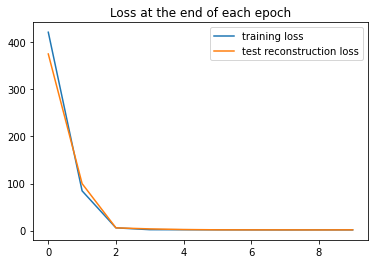

In [ ]:
plot_loss(train_losses,test_losses)

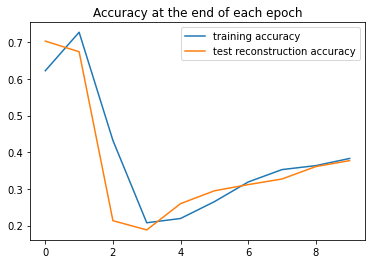

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMSNormal)

Test accuracy: 7921/21000 =  37.719%


In [ ]:
test_accuracy

37.71904761904762

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 1.5982589721679688


In [ ]:
weight_accuracies.append(test_accuracy)


In [ ]:
weight_losses.append(loss_term)

#### Plotting graphs for different weight intialisations

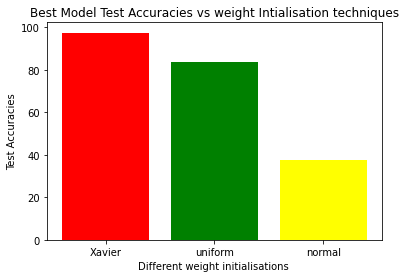

In [ ]:
# plotting a bar chart
left=[1,2,3]
height=weight_accuracies
tick_label=['Xavier','uniform','normal']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow'])
  
# naming the x-axis
plt.xlabel('Different weight initialisations ')
# naming the y-axis
plt.ylabel('Test Accuracies')
# plot title
plt.title('Best Model Test Accuracies vs weight Intialisation techniques')
  
# function to show the plot
plt.show()

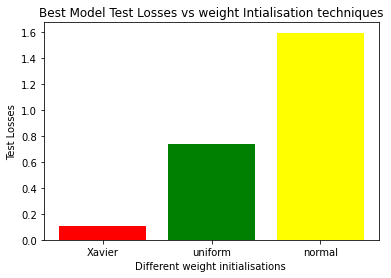

In [ ]:
# plotting a bar chart
left=[1,2,3]
height=weight_losses
tick_label=['Xavier','uniform','normal']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow'])
  
# naming the x-axis
plt.xlabel('Different weight initialisations ')
# naming the y-axis
plt.ylabel('Test Losses')
# plot title
plt.title('Best Model Test Losses vs weight Intialisation techniques')
  
# function to show the plot
plt.show()

## Learning rate Annealing
    Here we will use exponential learning rate annealing method of pytorch lr_scheduler
    on the best method RMSProp with different learning rates like 0.01,0.001,0.0005,0.0001
    we'll define new training loop to apply scheduler rate effectively 

### For learning rate lr=0.01

In [ ]:

def train_loss_accu(train_loader,model,scheduler,optimizer):

  import time
  start_time = time.time()

  epochs = 10
  train_losses = []
  test_losses = []
  train_correct = []
  test_correct = []
  
  

  for i in range(epochs):
      trn_corr = 0
      tst_corr = 0
      
      # Run the training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b+=1
          # Apply the model
          y_pred= model(X_train.view(100, -1))  # Here we flatten X_train
          loss = criterion(y_pred, y_train)
  
          # Tally the number of correct predictions
          predicted = torch.max(y_pred.data, 1)[1]
          batch_corr = (predicted == y_train).sum()
          trn_corr += batch_corr
          
          # Update parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print interim results
          if b%200 == 0:
              print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/49000]  loss: {loss.item():10.8f}  \
  accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
              
              ####### scheduler step for exponential annealing########
              scheduler.step()
              
             
      
      # Update train loss & accuracy for the epoch
      train_losses.append(loss)
      train_correct.append(trn_corr)
      # Run the testing batches
      
      with torch.no_grad():
          for b, (X_test, y_test) in enumerate(test_loader):

              # Apply the model
              y_val = model(X_test.view(500, -1))  # Here we flatten X_test

              # Tally the number of correct predictions
              predicted = torch.max(y_val.data, 1)[1] 
              tst_corr += (predicted == y_test).sum()
      
      # Update test loss & accuracy for the epoch
      loss = criterion(y_val, y_test)
      test_losses.append(loss)
      test_correct.append(tst_corr)

      
          
  print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  


  return train_losses,train_correct,test_losses,test_correct    #,final_outputs    

In [ ]:
RMS_accuracies=[]
RMS_losses=[]

In [ ]:


print("********************    For Learning rate  = {}   *********************".format(0.01))
torch.manual_seed(101)
modelRMS = MultilayerPerceptron()
modelRMS


********************    For Learning rate  = 0.01   *********************


MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accu(train_loader,modelRMS,scheduler,optimizer)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.28514996    accuracy:  70.385%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.17230114    accuracy:  80.733%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.10395326    accuracy:  94.035%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.16580720    accuracy:  94.108%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.08165231    accuracy:  95.425%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.19415605    accuracy:  95.480%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.11019706    accuracy:  96.445%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.11013088    accuracy:  96.278%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.09719494    accuracy:  96.625%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.16339943    accuracy:  96.748%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.10469028    accuracy:  97.315%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.14109151    accuracy:  97.248%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.20936216    accur

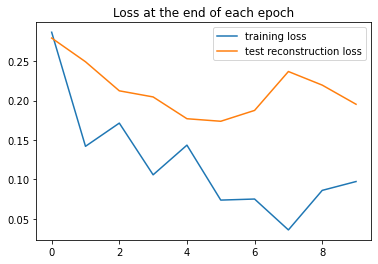

In [ ]:
plot_loss(train_losses,test_losses)

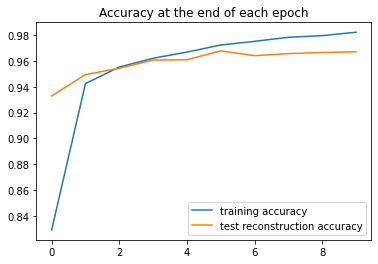

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)
print('Test Accuracy: {}'.format(test_accuracy))

Test accuracy: 20310/21000 =  96.714%
Test Accuracy: 96.71428571428571


In [ ]:
RMS_accuracies.append(test_accuracy)

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.15149185061454773


In [ ]:
RMS_losses.append(loss_term)

In [ ]:
RMS_losses

[0.15149185061454773]

### For learning rate =0.001

In [ ]:


print("********************    For Learning rate  = {}   *********************".format(0.001))
torch.manual_seed(101)
modelRMS = MultilayerPerceptron()
modelRMS


********************    For Learning rate  = 0.001   *********************


MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accu(train_loader,modelRMS,scheduler,optimizer)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.25186986    accuracy:  80.240%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.09518383    accuracy:  86.412%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.07703903    accuracy:  95.805%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.07532599    accuracy:  95.978%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.01932778    accuracy:  97.280%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.04489992    accuracy:  97.320%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.02140012    accuracy:  98.075%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.05426028    accuracy:  98.140%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.01696861    accuracy:  98.585%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.02026341    accuracy:  98.545%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.00205597    accuracy:  99.040%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.02311212    accuracy:  98.975%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.04544597    accur

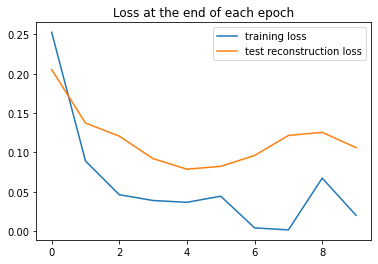

In [ ]:
plot_loss(train_losses,test_losses)

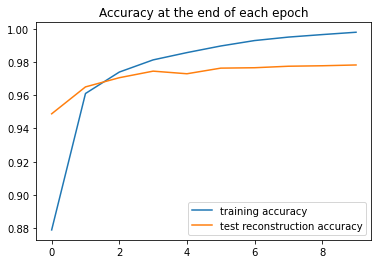

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)
print('Test Accuracy: {}'.format(test_accuracy))

Test accuracy: 20542/21000 =  97.819%
Test Accuracy: 97.81904761904762


In [ ]:
RMS_accuracies.append(test_accuracy)

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.09899059683084488


In [ ]:
RMS_losses.append(loss_term)

In [ ]:
RMS_losses

[0.15149185061454773, 0.09899059683084488]

### For learning rate lr=0.0005

In [ ]:


print("********************    For Learning rate  = {}   *********************".format(0.0005))
torch.manual_seed(101)
modelRMS = MultilayerPerceptron()
modelRMS


********************    For Learning rate  = 0.0005   *********************


MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accu(train_loader,modelRMS,scheduler,optimizer)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.34836709    accuracy:  77.990%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.13510603    accuracy:  83.942%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.13307731    accuracy:  93.805%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.12725629    accuracy:  94.185%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.05642991    accuracy:  95.770%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.11029258    accuracy:  96.007%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.08251811    accuracy:  96.910%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.08234553    accuracy:  96.945%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.04006115    accuracy:  97.510%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.11489674    accuracy:  97.500%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.02473262    accuracy:  98.045%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.12181097    accuracy:  98.017%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.08106781    accur

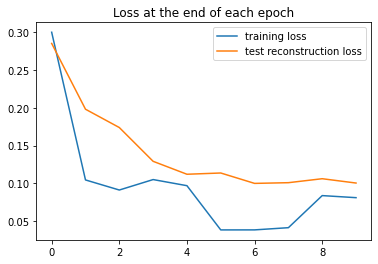

In [ ]:
plot_loss(train_losses,test_losses)

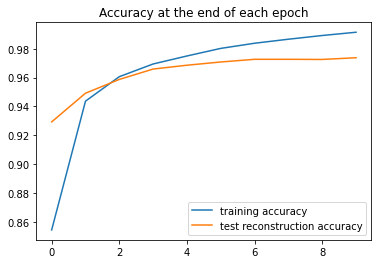

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)
print('Test Accuracy: {}'.format(test_accuracy))

Test accuracy: 20449/21000 =  97.376%
Test Accuracy: 97.37619047619047


In [ ]:
RMS_accuracies.append(test_accuracy)

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.09352946281433105


In [ ]:
RMS_losses.append(loss_term)

In [ ]:
RMS_losses

[0.15149185061454773, 0.09899059683084488, 0.09352946281433105]

### For learning rate lr=0.0001

In [ ]:


print("********************    For Learning rate  = {}   *********************".format(0.0001))
torch.manual_seed(101)
modelRMS = MultilayerPerceptron()
modelRMS


********************    For Learning rate  = 0.0001   *********************


MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

In [ ]:
train_losses,train_correct,test_losses,test_correct = train_loss_accu(train_loader,modelRMS,scheduler,optimizer)

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.80393541    accuracy:  62.060%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.48492059    accuracy:  71.528%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.39591762    accuracy:  86.055%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.46021652    accuracy:  86.532%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.32854962    accuracy:  88.445%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.27423835    accuracy:  88.640%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.38256446    accuracy:  89.455%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.26348144    accuracy:  89.718%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.32450476    accuracy:  90.590%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.37747395    accuracy:  90.685%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.18347727    accuracy:  91.400%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.45864701    accuracy:  91.230%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.32003987    accur

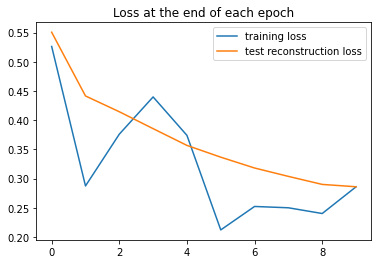

In [ ]:
plot_loss(train_losses,test_losses)

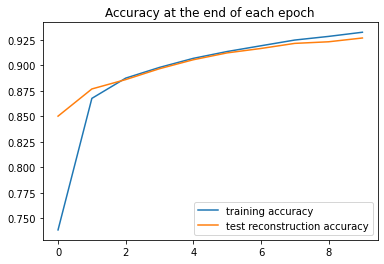

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
(test_accuracy,test_loss)=test_loss_accuracy(test_data,modelRMS)
print('Test Accuracy: {}'.format(test_accuracy))

Test accuracy: 19463/21000 =  92.681%
Test Accuracy: 92.68095238095238


In [ ]:
RMS_accuracies.append(test_accuracy)

In [ ]:
losses=[i.item() for i in test_loss]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.24516627192497253


In [ ]:
RMS_losses.append(loss_term)

In [ ]:
RMS_losses

[0.15149185061454773,
 0.09899059683084488,
 0.09352946281433105,
 0.24516627192497253]

In [ ]:
RMS_losses.append(loss_term)

In [ ]:
RMS_accuracies

[96.71428571428571, 97.81904761904762, 97.37619047619047, 92.68095238095238]

### Plotting bar graphs for accuracies and loss

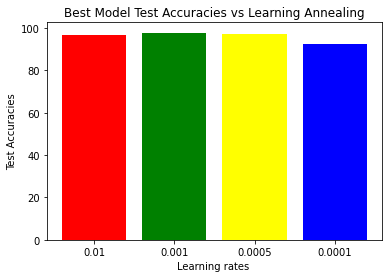

In [ ]:
# plotting a bar chart
left=[1,2,3,4]
height=RMS_accuracies
tick_label=['0.01','0.001','0.0005','0.0001']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow','blue'])
  
# naming the x-axis
plt.xlabel('Learning rates ')
# naming the y-axis
plt.ylabel('Test Accuracies')
# plot title
plt.title('Best Model Test Accuracies vs Learning Annealing')
  
# function to show the plot
plt.show()

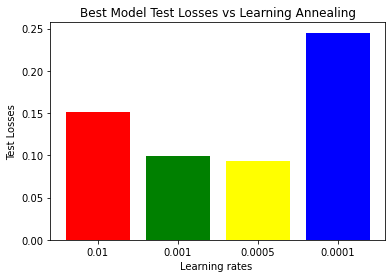

In [ ]:
# plotting a bar chart
left=[1,2,3,4]
height=RMS_losses
tick_label=['0.01','0.001','0.0005','0.0001']
plt.bar(left, height, tick_label = tick_label,
        width = 0.8, color = ['red', 'green','yellow','blue'])
  
# naming the x-axis
plt.xlabel('Learning rates ')
# naming the y-axis
plt.ylabel('Test Losses')
# plot title
plt.title('Best Model Test Losses vs Learning Annealing')
  
# function to show the plot
plt.show()

## Part 2
    In this section we will use the train,test data sets which are latent space representation obtained from under complete auto encoder of second question

### Data preprocessing for latent space representation
  we will load from numpy files and convert them into tensor data set inorder to convert them into data loader compatible data. After that we need to change the shapes of the y_train and y_test (i.e flatten) before calculating the loss 

In [ ]:
train=np.load('train.npy')
print(len(train))

train_labels=np.load('train-labels.npy')
print(len(train_labels))

print(train[0])
train.shape



49000
49000
[ 0.          0.          0.          0.          0.          0.
  0.          0.         13.00463295  0.         40.74394226  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          6.00007248  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          8.37154865  0.          0.
 21.28633308  0.          0.          0.        ]


(49000, 40)

In [ ]:
test=np.load('test.npy')
print(len(test))

test_labels=np.load('test-labels.npy')
print(len(test_labels))

print(test[0])
test.shape

21000
21000
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 23.8663826  15.17771339  0.          0.          0.          0.
  0.          0.         22.32218361  0.          0.          0.
  0.          0.          0.          0.         18.48301506  0.
  0.          0.          0.          0.        ]


(21000, 40)

In [ ]:
y_test=test_labels   #.reshape(1,21000)
#y_test=y_test[0]
y_test

array([[   3],
       [   0],
       [   4],
       ...,
       [   0],
       [   5],
       [   5]])

In [ ]:
y_train=train_labels    #.reshape(1,49000)
#y_train=y_train[0]
y_train

array([[9.],
       [4.],
       [1.],
       ...,
       [4.],
       [9.],
       [1.]])

 `we got best accuracy with Xavier weight intialisation and learning rate id 0.001`

In [ ]:

a = train
train = torch.from_numpy(a)
train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
a = test
test = torch.from_numpy(a)
test

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [39.9069,  0.0000,  8.7847,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 9.1359,  0.0000,  8.4719,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

#### Reference : `https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader`

In [ ]:
tensor_x = torch.Tensor(train) # transform to torch tensor
tensor_y = torch.LongTensor(y_train)

print(tensor_x.size())
print(tensor_y.size())


my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset



tensor_x_test= torch.Tensor(test) # transform to torch tensor
tensor_y_test = torch.LongTensor(y_test)

my_dataset_test = TensorDataset(tensor_x_test,tensor_y_test) # create your datset



torch.Size([49000, 40])
torch.Size([49000, 1])


In [ ]:
new_train_loader = DataLoader(my_dataset,batch_size=100, shuffle=True)
new_test_loader = DataLoader(my_dataset_test,batch_size=500, shuffle=False)

### Implementing model on data obtained from auto encoder 


In [ ]:
torch.manual_seed(101)
modelRMS = FeedForwardNetwork(in_sz=40)
modelRMS

FeedForwardNetwork(
  (fc1): Linear(in_features=40, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(modelRMS.parameters(), lr=0.001)

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [ ]:
count_parameters(modelRMS)

 10240
   256
 32768
   128
  8192
    64
  2048
    32
   320
    10
______
 54058


In [ ]:

import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    loss=0
    for b, (X_train, y_train) in enumerate(new_train_loader):

        b+=1
        # Apply the model
        y_pred= modelRMS(X_train.view(100, -1))  # Here we flatten X_train
        y_train=torch.reshape(y_train,(-1,))
        #print(y_train.size())
        #print(y_pred.size())
        #break
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/49000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    #break
    train_losses.append(loss)
    train_correct.append(trn_corr)
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(new_test_loader):
            y_test=torch.reshape(y_test,(-1,))

            # Apply the model
            y_val = modelRMS(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch:  200 [ 20000/49000]  loss: 0.09560195  accuracy:  96.460%
epoch:  0  batch:  400 [ 40000/49000]  loss: 0.05919057  accuracy:  97.188%
epoch:  1  batch:  200 [ 20000/49000]  loss: 0.17038815  accuracy:  97.920%
epoch:  1  batch:  400 [ 40000/49000]  loss: 0.07218672  accuracy:  97.942%
epoch:  2  batch:  200 [ 20000/49000]  loss: 0.08683226  accuracy:  98.025%
epoch:  2  batch:  400 [ 40000/49000]  loss: 0.04515415  accuracy:  98.050%
epoch:  3  batch:  200 [ 20000/49000]  loss: 0.06211601  accuracy:  98.045%
epoch:  3  batch:  400 [ 40000/49000]  loss: 0.01809677  accuracy:  98.065%
epoch:  4  batch:  200 [ 20000/49000]  loss: 0.06983701  accuracy:  98.205%
epoch:  4  batch:  400 [ 40000/49000]  loss: 0.07771728  accuracy:  98.220%
epoch:  5  batch:  200 [ 20000/49000]  loss: 0.14115325  accuracy:  98.170%
epoch:  5  batch:  400 [ 40000/49000]  loss: 0.01515488  accuracy:  98.170%
epoch:  6  batch:  200 [ 20000/49000]  loss: 0.01242213  accuracy:  98.110%
epoch:  6  b

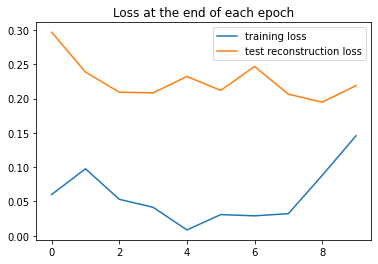

In [ ]:
plot_loss(train_losses,test_losses)

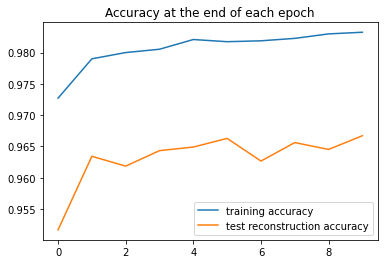

In [ ]:
plot_accuracy(train_correct,test_correct)

In [ ]:
len(my_dataset_test)

21000

In [ ]:
test_load_all = DataLoader(my_dataset_test, batch_size=21000, shuffle=False)
test_load_all

In [ ]:

test_losses=[]

with torch.no_grad():
  correct = 0
  loss=0
  for X_test, y_test in test_load_all:
    y_test=torch.reshape(y_test,(-1,))
    y_val = modelRMS(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
    
    predicted = torch.max(y_val,1)[1]
    
    correct += (predicted == y_test).sum()    
    
    loss = criterion(y_val, y_test)

  test_losses.append(loss)
    
  print(f'Test accuracy: {correct.item()}/{len(my_dataset_test)} = {correct.item()*100/(len(my_dataset_test)):7.3f}%')

Test accuracy: 20301/21000 =  96.671%


In [ ]:
losses=[i.item() for i in test_losses]
loss_term=np.mean(np.array(losses))
print('Test loss: {}'.format(loss_term))

Test loss: 0.1574525088071823


### Observations:
  We can clearly observe that test accuracy from best model is 97.505% and the test accuracy from latent space representation is 96.671% which near to the best model. So our model is performing good on the latent space representation. there is minute decrease in accuracy which is expected. training accuracy is also high